# Implementation Of The Finite Difference Scheme For The Diffusion Equation


In this section we implement a numeric solution to the diffusion equation. We have already found the analytic solution, which is 
$$
    \newcommand{\qty}[1]
    {
        \left({#1}\right)
    }
    \newcommand{\qtys}[1]
    {
        \left[{#1}\right]
    }
$$     

\begin{align}
	C_-(x,0) = C_b\qty{1- \frac{4}{\pi} \sum_{n=0}^\infty \frac{(-1)^n}{(2n+1)}\exp\qtys{-\qty{\frac{(2n+1)\pi}{2}}^2\frac{D_- t}{\delta^2}}\cos\qty{\frac{(2n+1)\pi}{2} \frac{x}{\delta}}} -\frac{r\delta}{D}\qty{1-\xi - \frac{8}{\pi^2}\sum_{n=0}^\infty \frac{1}{(2n+1)^2}\exp\qtys{-\qty{\frac{(2n+1)\pi}{2}}^2\frac{D_- t}{\delta^2}}\cos\qty{\frac{(2n+1)\pi}{2} \frac{x}{\delta}}}.
	\label{eq:solution-diffusion}
\end{align}




In this section we will compute the diffusion equation numerically and add the chemical reaction as a border condition.

## Numeric Solution - Consumtion Reaction Rate

For this case, we have the same equation, but border conditions at the interface change a little. We have

\begin{align}
	\rho(\xi = 1, \tau) = 0, \\
	D \frac{\partial \rho}{\partial \xi} (\xi = 0, \tau) = \frac{\delta r}{C_b},\\
	\rho(\xi, \tau = 0) = -1.
\end{align}

Here, we have used the adimensional parameters 

\begin{align}
    \tau = \frac{D t }{\delta ^2},\\
    \xi = \delta x
\end{align}


The approach in discretizing is exactly the same as in the previous case, with the exception of the first equation (k = 1) in which we get the following border condition

\begin{align}
    \frac{D}{\delta}\frac{\partial \rho}{\partial \xi} = \frac{r}{C_b}.
\end{align}

In discretized form

\begin{align}
    \frac{D}{\delta}\frac{(\rho^{n,1}-\rho^{n,0})}{\Delta \xi} = \frac{r}{C_b},
\end{align}

where $r$ is the reaction rate. In discretized form, this border condition can be written as

\begin{align}
    \rho^{n,0} = \rho^{n,1} - \frac{r\delta }{D C_b}\Delta \xi.
\end{align}


This means that the discrete equations are (in matrix form)

\begin{align}
    \bf{\underline{A}} \bf{\rho^{n+1}}  = \bf{\rho^n} + \bf{b},
\end{align}

where $\bf{\underline{A}}$ is the same as the diffusion-only case and 

\begin{align}
    \bf{b} = \begin{bmatrix}
                -\alpha\frac{r\delta}{DC_b} \Delta \xi\\
                0\\
                \vdots \\
                0
                \end{bmatrix}
\end{align}

On the other hand,

\begin{align}
r = \frac{\partial C_s}{\partial t}\bigg|_{\xi = 0} = \frac{\partial zF C_s}{\partial t}\frac{1}{zF}\bigg|_{\xi = 0} = \frac{\partial Q_s}{\partial t}\frac{1}{zF}\bigg|_{\xi = 0} =  \frac{i_0}{zF}.
\end{align}

The following code computes the numeric solution for this case, with $r = \frac{150 \times 10}{{2 \cdot  96 485.3329 }} \frac{A}{m^2 C} = 7.77\times 10^{-4}$, which means that the $\bf{b}$ vector is 

\begin{align}
    \bf{b} = \begin{bmatrix}
                - 7.0093 \times 10^{-3} \\
                0\\
                \vdots \\
                0
                \end{bmatrix}
\end{align}


In [1]:
#imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags

# Define grid parameters
# D = 1.07e-9 #Diffusion Coefficient
N = 10000
M = 500
xi = np.linspace(0,1, M)
tau = np.linspace(0,1, N) #shape is N+1

dtau = 1/(N)  # N Partitions
dxi = 1/(M) # N Partitions 
a = dtau / dxi ** 2 

#Reaction rate parameter
r = 150 * 1e-1


# Define the coefficient matrix
di = ( 1 + 2 * a ) * np.ones(M-2)
di[0] = ( 1 + a )
A = diags(np.array([- a * np.ones(M-3), di, - a * np.ones(M-3)]), [-1, 0, 1], shape=(M-2, M-2)).toarray()
A_inv = np.asarray(np.linalg.inv(A))

def C(t):
    # Set up initial conditions for \rho
    Cb = 100 
    D = 1.07e-9 # Diffusion Coefficient
    d = 1e-9 # Laminar flow sheet

    
    rho = np.zeros([N, M])
    b = np.zeros(M-2)
    b[0] = -a * dxi * d * r / (Cb * D) 
    rho = np.zeros([N, M])

    rho[0, :] = - 1
    rho[0, :] = - 1
    rho[:, -1] = 0    
    rho[:, 0] = rho[:, 1]
    
    #Starting iteration
    for n in range(0, N-1):
        rho[n+1, 1:M-1] = np.matmul(A_inv, rho[n, 1:M-1] + b)
        rho[n+1, 0] = rho[n+1, 1]
        
    n = int(t/dtau)
    
    return Cb * (np.ones(M) + rho[n, :])

#Cm is the imported analytical solution
def remove_points(A):
    A = np.delete(A, [1, 2, 3])
    for i in range(0,int(len(A)/4)):
        index = i+4
        A = np.delete(A, [index-2, index-1, index])
    return A

Series truncation at n = 14 with maximnum local error 5.7125187754785553e-11%
Series truncation at n = 5 with maximnum local error 2.3225772213719132e-11%
Series truncation at n = 4 with maximnum local error 4.502263112310681e-13%
Series truncation at n = 2 with maximnum local error 6.96773166411574e-11%
Series truncation at n = 2 with maximnum local error 9.443058589831585e-12%


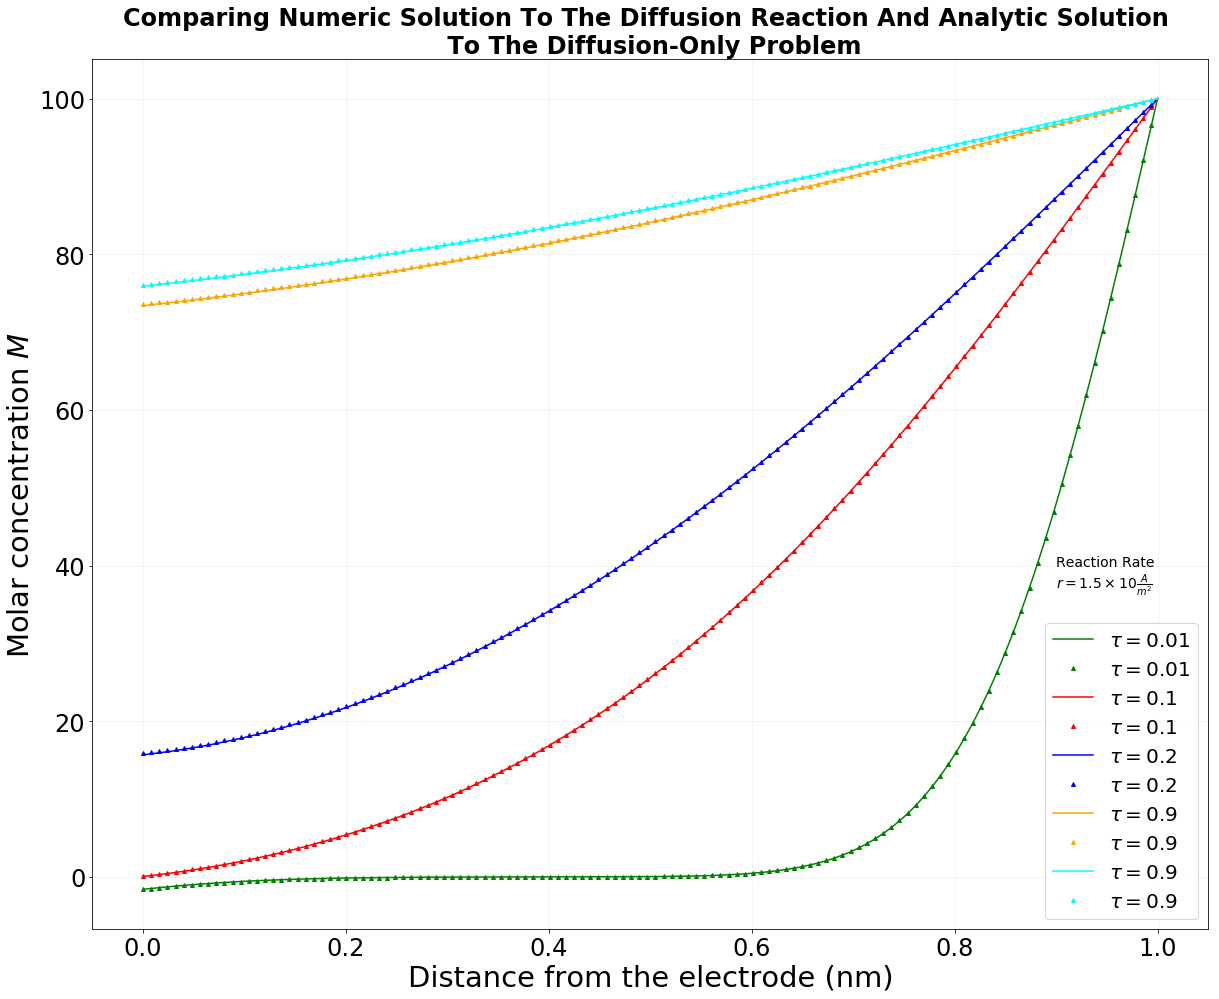

In [2]:
import analyticDiffusionReaction
import matplotlib.pyplot as plt


Cm = analyticDiffusionReaction.C_an
mw = 4
fs = 24
xi2 = remove_points(xi) # this is done to avoid cluttering of numeric points over the analytic solution
fig = plt.figure(figsize=(20,16))
plt.grid(True, color= '#F2F2F2')
plt.title('Comparing Numeric Solution To The Diffusion Reaction And Analytic Solution \n To The Diffusion-Only Problem', fontsize=fs, fontweight='bold')
plt.plot(xi, Cm(xi, 0.01, r), 'g-', label=r'$\tau=0.01$')
plt.plot(xi2, remove_points(C(0.01)), 'g^', markersize=mw, label=r'$\tau=0.01$')
plt.plot(xi, Cm(xi, 0.1, r), 'r-', label=r'$\tau = 0.1$')
plt.plot(xi2, remove_points(C(0.1)), 'r^', markersize=mw, label=r'$\tau = 0.1$')
plt.plot(xi, Cm(xi, 0.2, r), 'b-', label = r'$\tau=0.2$')
plt.plot(xi2, remove_points(C(0.2)), 'b^', markersize=mw, label = r'$\tau=0.2$')
plt.plot(xi, Cm(xi, 0.9, r), '-', color="orange", label = r'$\tau=0.9$')
plt.plot(xi2, remove_points(C(0.9)), '^', markersize=mw, color="orange", label = r'$\tau=0.9$')
plt.plot(xi, Cm(xi, 0.99, r), '-', color="aqua", label = r'$\tau=0.9$')
plt.plot(xi2, remove_points(C(0.99)), '^', markersize=mw, color="aqua", label = r'$\tau=0.9$')
plt.xlabel(r'Distance from the electrode (nm)', fontsize=fs+5)
plt.ylabel(r'Molar concentration $M$', fontsize=fs+5)
plt.text(0.9, 40, r'Reaction Rate', fontsize = 14, color = 'black')
plt.text(0.9, 37, r'$r =  1.5 \times 10 \frac{A}{m^2}$', fontsize = 14, color = 'black')
plt.legend(fontsize = fs-4)
plt.xticks(size = fs)
plt.yticks(size = fs)
plt.savefig('../../../img/diffusion-reaction-comparison.eps', format='eps', dpi=1000, fontsize=16, fontweight='bold')
plt.show()


Series truncation at n = 14 with maximnum local error 5.7125187754785553e-11%
Series truncation at n = 5 with maximnum local error 2.3225772213719132e-11%
Series truncation at n = 4 with maximnum local error 4.502263112310681e-13%
Series truncation at n = 2 with maximnum local error 6.96773166411574e-11%
Series truncation at n = 2 with maximnum local error 9.443058589831585e-12%


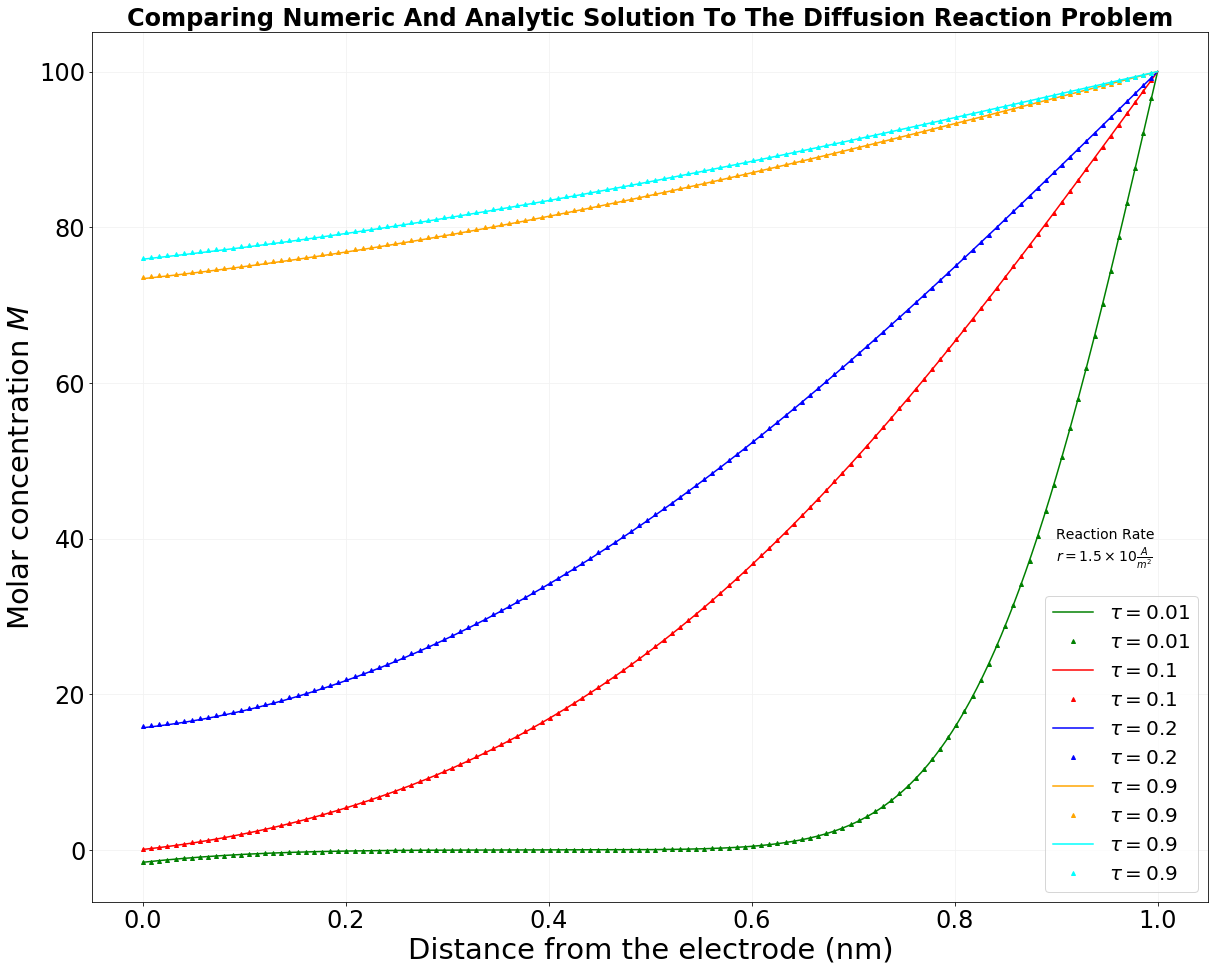

In [3]:
import analyticv2 
import matplotlib.pyplot as plt


Cm = analyticDiffusionReaction.C_an
mw = 4
fs = 24
fig = plt.figure(figsize=(20,16))
plt.grid(True, color= '#F2F2F2')
plt.title('Comparing Numeric And Analytic Solution To The Diffusion Reaction Problem', fontsize=fs, fontweight='bold')
plt.plot(xi, Cm(xi, 0.01, r), 'g-', label=r'$\tau=0.01$')
plt.plot(xi2, remove_points(C(0.01)), 'g^', markersize=mw, label=r'$\tau=0.01$')
plt.plot(xi, Cm(xi, 0.1, r), 'r-', label=r'$\tau = 0.1$')
plt.plot(xi2, remove_points(C(0.1)), 'r^', markersize=mw, label=r'$\tau = 0.1$')
plt.plot(xi, Cm(xi, 0.2, r), 'b-', label = r'$\tau=0.2$')
plt.plot(xi2, remove_points(C(0.2)), 'b^', markersize=mw, label = r'$\tau=0.2$')
plt.plot(xi, Cm(xi, 0.9, r), '-', color="orange", label = r'$\tau=0.9$')
plt.plot(xi2, remove_points(C(0.9)), '^', markersize=mw, color="orange", label = r'$\tau=0.9$')
plt.plot(xi, Cm(xi, 0.99, r), '-', color="aqua", label = r'$\tau=0.9$')
plt.plot(xi2, remove_points(C(0.99)), '^', markersize=mw, color="aqua", label = r'$\tau=0.9$')
plt.xlabel(r'Distance from the electrode (nm)', fontsize=fs+5)
plt.ylabel(r'Molar concentration $M$', fontsize=fs+5)
plt.text(0.9, 40, r'Reaction Rate', fontsize = 14, color = 'black')
plt.text(0.9, 37, r'$r =  1.5 \times 10 \frac{A}{m^2}$', fontsize = 14, color = 'black')
plt.legend(fontsize = fs-4)
plt.xticks(size = fs)
plt.yticks(size = fs)
plt.savefig('../../../img/diffusion-reaction-comparison.eps', format='eps', dpi=1000, fontsize=16, fontweight='bold')
plt.show()

